# LSTM Time Series Deep Learning and Adversarial Attacks

## 1. About this Notebook

See the project [README](https://github.com/duanegoodner/lstm_adversarial_attack) for general information on the dataset and approach used in this notebook.

The implementation details for this project are encapsulated in various classes and methods defined in modules under the project `src` directory, and various intermediate data structures and logs are saved in the project `data` directory. Most of the code in this notebook simply instantiates top-level classes and makes calls to their methods without revealing implementation details. Please look to code in the `src` and `data` directories if you interested in lower level details. The import paths as well as the terminal output shown in this notebook will provide some guidance on where to look within those directories.

## 2. Project Setup

Before running this notebook, review the project README at https://github.com/duanegoodner/lstm_adversarial_attack, and complete all steps in the "How to run this project" section.

## 3. Imports
Most of the necessary standard library imports and external package imports are handled modules in the `src` directory, but we need to import a few here.

### 3.1 Standard Library Imports

In [2]:
import pprint
import sys

### 3.2 External Packages

In [3]:
import numpy as np
import torch
from torch.utils.data import random_split

### 3.3 Internal Project Modules and Sub-packages
To help gain a sense of project structure, we will import internal packages and modules as-needed (i.e. immediately before the notebook code cells where they are first used). For now, we import the project `src` path defined in `lstm_adversarial_attack/notebooks/src_path`, add it to sys.path (so we can easily import project code), and we import project config files.

In [4]:
import src_paths
sys.path.append(str(src_paths.lstm_adversarial_attack_pkg))
import lstm_adversarial_attack.config_paths as cfg_paths
import lstm_adversarial_attack.config_settings as cfg_set

## 3. Database Queries
We need to run four queries on the MIMIC-III PostgreSQL database. The paths to files containing the queries are stored in a list as `DB_QUERIES` in the project `config_paths` file:

In [4]:
pprint.pprint(cfg_paths.DB_QUERIES)

[PosixPath('/home/devspace/project/src/mimiciii_queries/icustay_detail.sql'),
 PosixPath('/home/devspace/project/src/mimiciii_queries/pivoted_bg.sql'),
 PosixPath('/home/devspace/project/src/mimiciii_queries/pivoted_lab.sql'),
 PosixPath('/home/devspace/project/src/mimiciii_queries/pivoted_vital.sql')]


To connect to the database, and execute the queries, we instantiate a `MimiciiiDatabaseAccess` object from module `mimiciii_database` of project sub-package `query_db` and use its .connect(), .run_sql_queries() and .close_connection() methods.

In [ ]:
import lstm_adversarial_attack.query_db.mimiciii_database as mdb

db_access = mdb.MimiciiiDatabaseAccess(
    dotenv_path=cfg_paths.DB_DOTENV_PATH, output_dir=cfg_paths.DB_OUTPUT_DIR
)
db_access.connect()
db_query_results = db_access.run_sql_queries(
    sql_query_paths=cfg_paths.DB_QUERIES
)
db_access.close_connection()

The results of each `.sql` query is saved to a `.csv` file. The path to each of these files is shown in the terminal output above. The output path of the queries is defined by variable `DB_OUTPUT_DIR` in the project `config_settings` file.

## 4. Preprocessor

### 4.1 Instantiate a Preprocessor object
We import the `preprocessor` module from internal sub-package `preprocess`, instantiate a `Preprocessor` object, and examine its .preprocess_modules data member. 

In [5]:
import lstm_adversarial_attack.preprocess.preprocessor as pre
preprocessor = pre.Preprocessor()

We can get a general idea of how the `lstm_adversarial_attack.preprocess` sub-package works by looking at the `Preprocessor` object's `.preprocessor_modules` data member.

In [6]:
pprint.pprint([item.__class__ for item in preprocessor.preprocess_modules])

[<class 'lstm_adversarial_attack.preprocess.prefilter.Prefilter'>,
 <class 'lstm_adversarial_attack.preprocess.icustay_measurement_combiner.ICUStayMeasurementCombiner'>,
 <class 'lstm_adversarial_attack.preprocess.sample_list_builder.FullAdmissionListBuilder'>,
 <class 'lstm_adversarial_attack.preprocess.feature_builder.FeatureBuilder'>,
 <class 'lstm_adversarial_attack.preprocess.feature_finalizer.FeatureFinalizer'>]


* Prefilter reads the database query outputs into Pandas Dataframes, removes all data related to patients younger than 18 years in age, ensures consistent column naming formats, and takes care of datatype details.
* ICUStayMeasurementCombiner performs various joins (aka "merges" in the language of Pandas) to combine lab and vital sign measurement data with ICU stay data.
* FullAdmissionListBuilder generates a list consisting of one FullAdmissionData object per ICU stay. The attributes of a FullAdmissionData object include ICU stay info, and a dataframe containing the measurement and timestamp data for all vital sign and lab data associated with the ICU stay.
* FeatureBuilder resamples the time series datafame to one-hour intervals, imputes missing data, winsorizes measurement values (with cutoffs at the 5th and 95th global percentiles), and normalizes the measuremnt values so all data are between 0 and 1.
* FeatureFinalizer selects the data observation time window (default starts at hospital admission time and ends 48 hours after admission). This module outputs the entire dataset features as a list of numpy arrays, and the mortality labels as a list of integers. These data structures (saved as .pickle files) will be convenient starting points when the `tune_train` and `attack` sub-packages need to create PyTorch Datasets.

Now that we have a some background info, we are ready to run the Preprocessor.

In [ ]:
preprocessed_resources = preprocessor.preprocess()

## 5. Pytorch Dataset object

### 5.1 Create the Dataset
We import module `x19_mort_general_dataset` and use it along with files saved by the Preprocessor's Feature Finalizer module to insantiate a Pytorch Dataset

In [7]:
import lstm_adversarial_attack.x19_mort_general_dataset as xmd
dataset = xmd.X19MGeneralDataset.from_feature_finalizer_output()

### 5.2 Examine the Dataset

#### 5.2.1 Dataset size, tensor shapes, and data types 

In [8]:
print(f"Number of samples in dataset = {len(dataset)}\n")
print(f"Type returned by dataset.__getitem__ = {type(dataset[0])}\n")
print(
    f"Length of each tuple returned by dataset.__getitem__ = {len(dataset[0])}"
)
print(
    "\nObject type, dimensionality, and datatype of each element in a tuple"
    " returned by dataset.__getitem__:"
)
print(tuple([(type(item), item.dim(), item.dtype) for item in dataset[0]]))
print(f"\ninput size (# columns) of each feature matrix is:\n"
     f"{np.unique([item.shape[1] for item in dataset[:][0]]).item()}\n")

Number of samples in dataset = 41951

Type returned by dataset.__getitem__ = <class 'tuple'>

Length of each tuple returned by dataset.__getitem__ = 2

Object type, dimensionality, and datatype of each element in a tuple returned by dataset.__getitem__:
((<class 'torch.Tensor'>, 2, torch.float32), (<class 'torch.Tensor'>, 0, torch.int64))

input size (# columns) of each feature matrix is:
19



#### 5.2.2 Distributions of feature sequence lengths and label values

In [9]:
print("Distribution of input sequence lengths (# rows):")
print("length\tcounts")
unique_sequence_lengths, sequence_length_counts = np.unique(
    [item.shape[0] for item in dataset[:][0]], return_counts=True
)
print(
    np.concatenate(
        (
            unique_sequence_lengths.reshape(-1, 1),
            sequence_length_counts.reshape(-1, 1),
        ),
        axis=1,
    )
)

print("\nLabel counts:")
print("value\tcounts")
unique_labels, label_counts = np.unique([dataset[:][1]], return_counts=True)
print(
    np.concatenate(
        (unique_labels.reshape(-1, 1), label_counts.reshape(-1, 1)), axis=1
    )
)

Distribution of input sequence lengths (# rows):
length	counts
[[    6     1]
 [   13     1]
 [   14     1]
 [   16     2]
 [   17     4]
 [   18     3]
 [   19     8]
 [   20    12]
 [   21    25]
 [   22    49]
 [   23    84]
 [   24   144]
 [   25   126]
 [   26   110]
 [   27    93]
 [   28    95]
 [   29    84]
 [   30    90]
 [   31    75]
 [   32    99]
 [   33    98]
 [   34   113]
 [   35   148]
 [   36   152]
 [   37   189]
 [   38   199]
 [   39   220]
 [   40   178]
 [   41   231]
 [   42   203]
 [   43   211]
 [   44   191]
 [   45   185]
 [   46   221]
 [   47   474]
 [   48 37832]]

Label counts:
value	counts
[[    0 37338]
 [    1  4613]]


## 6. Model Hyperparameter Tuning

### 6.1 Tuning Parameters

We define the following architecture for our LSTM predictive model

| Item  | Detail #1 | Detail #2| Detail #3 |
| :-------------- | :---------| :---------| :---------
| Bidirectional LSTM | input size = 19 | # hidden states per direction = *x<sub>1</sub>* | activation = ReLU or Tanh  |
| Dropout | P<sub>dropout</sub> = *x<sub>2</sub>* | -  | -  |
| Fully Connected Layer #1 | input size = *2x<sub>1</sub>*| output size = *x<sub>3</sub>* | activation = ReLU or Tanh |
| Fully Connected Layer #2 | input size = *x<sub>3</sub>* | output size = 2 | activation = Softmax |
| Optimizer | type = SGD or RMSProp or Adam | learning rate = *x<sub>4</sub>* | - |

*x<sub>1</sub>*, *x<sub>2</sub>*, *x<sub>3</sub>*, *x<sub>4</sub>*, activation functions for the LSTM and FC #1, the optimizer type, and learning rate will be determined through hyperparameter tuning.

The `HyperParameterTuner` class in the `lstm_adversarial_attack.tune_train` sub-package implements a K-fold (default K = 5) cross-validation tuning scheme that utilizes the Optuna framework. For a given set of hyperparameters, the `HyperParameterTUner.objective_fn()` returns the mean validation loss across the K folds, and this mean loss is used as a minimization target by an Optuna `TPESampler` to select new sets of hyperparameters for additional trials. `HyperParameterTuner` also uses an Optuna `MedianPruner` to stop unpromising trials early.


### 6.2 General Approach
The `HyperParameterTuner` class in the `lstm_adversarial_attack.tune_train` sub-package implements a Stratified K-fold (default K = 5) cross-validation tuning scheme that utilizes the Optuna framework. When defining the dataset indices for each fold, we oversample from samples in the minority class (label = 1) using a For a given set of hyperparameters, the `HyperParameterTUner.objective_fn()` returns the mean validation loss across the K folds, and this mean loss is used as a minimization target by an Optuna `TPESampler` to select new sets of hyperparameters for additional trials. `HyperParameterTuner` also uses an Optuna `MedianPruner` to stop unpromising trials early.



### 6.2 Check for GPU
Model hyperparameter tuning (along with training, and model attacks) is implemented in PyTorch, and we really need a GPU to run things in a reasonable amount of time.

In [10]:
import torch

if torch.cuda.is_available():
    cur_device = torch.device("cuda:0")
else:
    cur_device = torch.device("cpu")

print(f"cur_device is {cur_device}")

cur_device is cuda:0


### 6.3 Instantiate and Examine TunerDriver
We then instantiate a TunerDriver object.

In [11]:
import lstm_adversarial_attack.tune_train.tuner_driver as td
tuner_driver = td.TunerDriver(
    device=cur_device,
    dataset=dataset,
    continue_study_path=cfg_paths.ONGOING_TUNING_STUDY_PICKLE,
    output_dir=cfg_paths.ONGOING_TUNING_STUDY_DIR,)

The `continue_study_path` and `output_dir` arguments passed to the `TunerDriver` constructor will allow us to build upon an existing Optuna study that contains learning from previously run trials. Model hyperparameter tuning is the most time-consuming part of the overall project pipeline, so we usually do not want to start from scratch. (But if you really want to start from scratch, just don't pass either of these path arguments to the `TuneDriver` constructor). For reference, the values of the two path variables we passed to the TunerDriver constructor are:

In [12]:
print(f"continue_study_path = {cfg_paths.ONGOING_TUNING_STUDY_PICKLE}")
print(f"output_dir = {cfg_paths.ONGOING_TUNING_STUDY_DIR}")

continue_study_path = /home/devspace/project/data/hyperparameter_tuning/continued_trials/checkpoints_tuner/optuna_study.pickle
output_dir = /home/devspace/project/data/hyperparameter_tuning/continued_trials


The TunerDriver object has many default parameters/attributes set by values in `cfg_paths` and `cfg_settings`. Note that its `.tuner` attribute is a `HyperParameterTuner` which in turn has a `.tuning_ranges` attribute that specifies our hyperparameter search space.

In [13]:
print(f"The tuner_driver.tuner is a {type(tuner_driver.tuner)}\n")
print("tuner_driver.tuner.tuning_ranges:")
pprint.pprint(tuner_driver.tuner.tuning_ranges)

The tuner_driver.tuner is a <class 'lstm_adversarial_attack.tune_train.hyperparameter_tuner.HyperParameterTuner'>

tuner_driver.tuner.tuning_ranges:
X19MLSTMTuningRanges(log_lstm_hidden_size=(5, 7),
                     lstm_act_options=('ReLU', 'Tanh'),
                     dropout=(0, 0.5),
                     log_fc_hidden_size=(4, 8),
                     fc_act_options=('ReLU', 'Tanh'),
                     optimizer_options=('Adam', 'RMSprop', 'SGD'),
                     learning_rate=(1e-05, 0.1),
                     log_batch_size=(5, 8))


### 6.4 Run the TunerDriver
The code in the next cell will run the Tuner Driver (and its associated HyperParameterTuner). Before starting, a few things to note:
* Depending your GPU compute power, running the full 30 trials could take 2 - 20 hours.
* If the study is stopped early (via CTRL-C or the Jupyter Stop button), learning from whatever trials have completed up to that point will be saved.
* While the tuning trials are running, look ahead to the next Markdown cell for instructions on how to monitor progress in Tensorboard (depending on your notebook output settings you may need to scroll down to see that cell)

In [ ]:
my_completed_study = tuner_driver.run(num_trials=30)

### 6.5 Monitor Tuning Progress with Tensorboard

While we are tuning hyperparameters, we can monitor results in Tensorboard. We can run tensorboard by starting a zsh session inside the project app container, and launching the tensorboard server from there:
```
$ docker exec -it lstm_aa_app_dev /bin/zsh
> tensorboard --logdir=/home/devspace/project/data/hyperparameter_tuning/continued_trials/tensorboard --host=0.0.0.0
```
Then, in your browser, go to: `http://localhost:6006/`

You should see something like the screenshot below.  The x-axis for all plots is epoch number. (Unfortunately, there is no good way to add axis labels in Tensorboard.)

In this example we are in the middle of running trial #21. Trial #20 completed the default number of epochs per fold (100). Trial #19 only ran 20 epochs because it was pruned by the Optuna `MeadianPruner`. 

![tensorboard_image](images/tensorboard_hyperparameter_tuning.png)



### 6.6 Select Final Hyperparameters
When we are done tuning, we can view our best set of hyperparameters by examining the `Optuna.Study` object from our above tuning run(s).


In [14]:
import lstm_adversarial_attack.resource_io as rio
study = rio.ResourceImporter().import_pickle_to_object(
    path=cfg_paths.ONGOING_TUNING_STUDY_PICKLE
)

print(f"The best trial result is from trial # {study.best_trial.number}.\n")
print("The set of hyperparameters from this trial are:")
pprint.pprint(study.best_params)


The best trial result is from trial # 20.

The set of hyperparameters from this trial are:
{'dropout': 0.029018875280141854,
 'fc_act_name': 'Tanh',
 'learning_rate': 0.0002784280532512521,
 'log_batch_size': 5,
 'log_fc_hidden_size': 4,
 'log_lstm_hidden_size': 7,
 'lstm_act_name': 'Tanh',
 'optimizer_name': 'Adam'}


### 6.7 Run K-Fold Cross Validation with "Best" Hyperparameters and Extended Training (More Epochs)
In the above tuning runs, we only run 100 epochs per fold (in the interest of reducing compute requirements). Based on the validation loss and AUC curves, it appears that we could improve our predictive performance (i.e. decrease validation loss, and increase AUC) by training longer. We now run another round of Stratified K-fold cross-validation with our best set of parameters with a larger number of epochs.

#### 6.7.1 Notes on our Method
Some caveats about our methodology:
* We are using "flat" cross-validation (as was done in previous studies on this dataset). This method computationally less expensive than nested cross-validation. Flat cross-validation has the potential to overestimate of model performance. In many cases the magnitude of overestimation is small. We also mitigate this effect by using a different set of (randomly generated) fold assignments than was used for hyperparameter tuning. 
* By selecting our hyperparameters based on the smaller number of epochs (100), we favor models that are faster to to train. It is possible that using a larger number of epochs in the tuning runs would have yielded a different (and better) set of "best" hyperparameters, but would also be computationally more expensive.


#### 6.7.2 Instantiate a CrossValidatorDriver
We use a CrossValidatorDriver object to run cross-validation with a single set of hyperparameters: 

In [15]:
import lstm_adversarial_attack.tune_train.cross_validator_driver as cvd
import lstm_adversarial_attack.x19_mort_general_dataset as xmd

cv_driver = cvd.CrossValidatorDriver.from_study_path(
        device=cur_device,
        dataset=dataset,
        study_path=cfg_paths.ONGOING_TUNING_STUDY_PICKLE
    )


Lets look at the data members of `cv_driver`

In [16]:
pprint.pprint(cv_driver.__dict__)

{'dataset': <lstm_adversarial_attack.x19_mort_general_dataset.X19MGeneralDataset object at 0x7f274f5b4ca0>,
 'device': device(type='cuda', index=0),
 'epochs_per_fold': 1000,
 'eval_interval': 10,
 'evals_per_checkpoint': 1,
 'hyperparameters': X19LSTMHyperParameterSettings(log_lstm_hidden_size=7,
                                                  lstm_act_name='Tanh',
                                                  dropout=0.029018875280141854,
                                                  log_fc_hidden_size=4,
                                                  fc_act_name='Tanh',
                                                  optimizer_name='Adam',
                                                  learning_rate=0.0002784280532512521,
                                                  log_batch_size=5),
 'num_folds': 5}


We will run 5-fold cross-validation using 1000 epochs per fold. We will evaluate performance (using a fold's validation set) and save a checkpoint once every 10 epochs. These settings are determined by the values of `CV_DRIVER_EPOCHS_PER_FOLD`, `CV_DRIVER_NUM_FOLDS`, `CV_DRIVER_EVAL_INTERVAL`, and `CV_DRIVER_EVALS_PER_CHECKPOINT` in `lstm_adversarial_attacker.config_settings`. The `.from_study_path()` class method we used to construct `cv_driver` extracts the best set of hyperparameters from `study_path` and passes them to the CrossValidationDriver constructor.

#### 6.7.3 Run Cross-Validation
We now call `cv_driver`'s `.run()` method to start the cross-validation runs.

In [20]:
cv_driver.run()

Training model.
Checkpoints will be saved in:
/home/devspace/project/data/cv_assessments/2023-06-17_23_57_23.366142/checkpoints/fold_0

Tensorboard logs will be saved in:
 /home/devspace/project/data/cv_assessments/2023-06-17_23_57_23.366142/tensorboard


fold_0, epoch_1, Loss: 0.5809
fold_0, epoch_2, Loss: 0.5482
fold_0, epoch_3, Loss: 0.5539
fold_0, epoch_4, Loss: 0.5446
fold_0, epoch_5, Loss: 0.5327
fold_0, epoch_6, Loss: 0.5328
fold_0, epoch_7, Loss: 0.5265
fold_0, epoch_8, Loss: 0.5267
fold_0, epoch_9, Loss: 0.5188
fold_0, epoch_10, Loss: 0.5096

fold_0 performance on test data:
Loss:		0.5205
Accuracy:	0.7805
AUC:		0.8674
Precision:	0.8303
Recall:		0.7065
F1:			0.7634

fold_0, epoch_11, Loss: 0.5153
fold_0, epoch_12, Loss: 0.5072
fold_0, epoch_13, Loss: 0.5015
fold_0, epoch_14, Loss: 0.4993
fold_0, epoch_15, Loss: 0.4998
fold_0, epoch_16, Loss: 0.4964
fold_0, epoch_17, Loss: 0.4916
fold_0, epoch_18, Loss: 0.4931
fold_0, epoch_19, Loss: 0.4902
fold_0, epoch_20, Loss: 0.4894

fold_0

### 6.7.4 Monitor Cross-Validation Progress in Tensorbard
Near the start of the terminal output from the previous code cell, look for the lines:
```
Checkpoints will be saved in:
/home/devspace/project/data/cv_assessments/<timestamped_directory_name>/tensorboard
```
Then, start a zsh shell inside the app container, and launch tensorboard server:
```
$ docker exec -it lstm_aa_app /bin/zsh
$ tensorboard --logdir=/home/devspace/project/data/cv_assessments/<timestamped_directory_name>/tensorboard --host=0.0.0.0
```
The Tensorboard output can now be viewed in your browswer at http://localhost:6006.

This Tensorboard screenshot was taken at the end of a 5-fold, 1000 epoch per fold cross-validation run.
![tensorboard_image](images/tensorboard_5fold_cv_best_params_1000epochs.png)

#### 6.7.5 Summarize Results
We can use a CrossValidationSummarizer to view best performance during training of each fold.

In [20]:
import lstm_adversarial_attack.tune_train.cross_validation_summarizer as cvs
cv_summarizer = cvs.CrossValidationSummarizer.from_cv_checkpoints_dir()
optimal_results_df = cv_summarizer.get_optimal_results_df(
        metric=cvs.EvalMetric.VALIDATION_LOSS,
        optimize_direction=cvs.OptimizeDirection.MIN,
    )

optimal_results_df


,epoch,train_loss,validation_loss,auc,accuracy,f1,precision,recall
0,1000,0.349761,0.345473,0.965451,0.967849,0.967258,0.989938,0.945595
1,920,0.345712,0.340703,0.970717,0.972498,0.971910,0.988792,0.955595
2,960,0.349870,0.349510,0.961955,0.963678,0.962606,0.989406,0.937220
3,920,0.353771,0.348848,0.963220,0.964304,0.963820,0.987560,0.941194
4,790,0.347615,0.343309,0.967401,0.969995,0.968765,0.988480,0.949821


We get the mean and standard deviation of each performance metric using:

In [21]:
optimal_results_df.describe().loc[["mean", "std"], optimal_results_df.columns != "epoch"]

,train_loss,validation_loss,auc,accuracy,f1,precision,recall
mean,0.349346,0.345568,0.965749,0.967665,0.966872,0.988835,0.945885
std,0.003010,0.003711,0.003475,0.003742,0.003763,0.000908,0.007193


### 6.9 Comparison with Prior Work

The table below compares the predictive performance of the LSTM model in this work with other LSTM-based models using the same dataset. The current model shows the best predictive performance among all models in the table based on AUC and F1 scores. 


|  | Authors       | Model      | Input Features | AUC             | F1              | Precision       | Recall          |
|-|------------|------------|----------------|-----------------|-----------------|-----------------|-----------------|
|1 |Sun et al.  | LSTM-128 + FC-32 + FC-2 | [13 labs, 6 vitals] x 48 hr  | 0.9094 (0.0053) | 0.5429 (0.0194) | 0.4100 (0.0272) | 0.8071 (0.0269) |
|2 |Tang et al. | LSTM-256 + FC-2 | [13 labs, 6 vitals] x 48 hr + demographic data  | 0.949 (0.003) | 0.623 (0.012) | 
| 3|Tang et al. | CNN + LSTM-256 + FC-2 | [13 labs, 6 vitals] x 48 hr + demographic data | 0.940 (0.0071) | 0.633 (0.031) | 
|4 |Tang et al. | CNN + LSTM-256 + FC-2 | [13 labs, 6 vitals] x 48 hr | 0.933 (0.006) | 0.587 (0.025) |
|5 |Tang et al. | LSTM-256 + FC-2 | [13 labs, 6 vitals] x 48 hr | 0.907 (0.006) | 0.526 (0.013) |
|6 |This work   | LSTM-128 + FC-16 + FC-2 | [13 labs, 6 vitals] x 48 hr  | 0.9657 (0.0035) | 0.9669 (0.0038) | 0.9888 (0.0009) | 0.9459 (0.0072) |

> **Notes** LSTM-X indicates an LSTM with X hidden layers. FC-X indicates a fully connected layer with an output size of X. All LSTMs are bidirectional. The demographic data used in studies #2 and #3 was obtained from MIMIC-III.
 

## 7. Run Adversarial Attack Algorithm on the Trained Model

$ X $

$$
a + b
$$

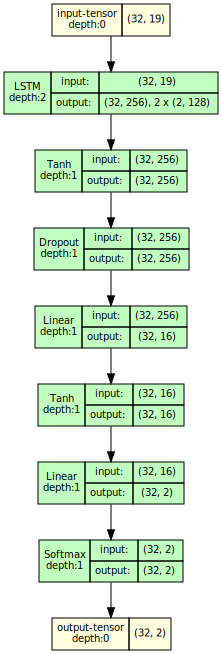

In [21]:
import sys
from pathlib  import Path
from torchview import draw_graph
import torch.nn as nn
import lstm_adversarial_attack.resource_io as rio
import lstm_adversarial_attack.config_paths as lcp
import lstm_adversarial_attack.tune_train.tuner_helpers as tuh


ongoing_study_path = lcp.ONGOING_TUNING_STUDY_PICKLE

ongoing_study = rio.ResourceImporter().import_pickle_to_object(
    path=ongoing_study_path
)

hyperparameters = tuh.X19LSTMHyperParameterSettings(**ongoing_study.best_params)
cur_model = tuh.X19LSTMBuilder(settings=hyperparameters).build_for_tensorboard()
# cur_model = nn.LSTM(
#     input_size=19,
#     hidden_size=128,
#     bidirectional=True,
#     batch_first=True
# )

cur_model_graph = draw_graph(model=cur_model, input_size=(32, 19), device="meta")

cur_model_graph.visual_graph
